In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from scipy.stats import stats
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3d projection
from psycopg2.extras import execute_batch

In [2]:
class SmartwatchHealthData:
    """
    A class to encapsulate analysis and processing of smartwatch health data.
    """
    
    def __init__(self, shd):
        """
        Initialize with a pandas DataFrame containing smartwatch health data.
        Parameters:
        -----------
        shd : pd.DataFrame
            Raw smartwatch health dataset.
        """
        self.shd = shd
    
    def data_frame(self):
        """
        Return the internal DataFrame.
        Returns:
        --------
        pd.DataFrame
            The current state of the smartwatch health data.
        """
        return self.shd
    
    def describe(self):
        """
        Print the data types of each column and count of missing values for the dataset.
        """
        print("Column Data Types:")
        print(self.shd.dtypes)
        print("\nMissing Value Count:")
        print(self.shd.isnull().sum())
    
    def standardize_activity_level(self):
        """
        Standardize entries in the 'Activity Level' column by:
        - Converting text to lowercase
        - Replacing underscores with spaces
        - Trimming leading/trailing whitespace
        - Mapping known incorrect or variant labels to canonical forms
        """
        self.shd['Activity Level'] = self.shd['Activity Level'].str.lower()
        self.shd['Activity Level'] = self.shd['Activity Level'].str.replace('_', ' ')
        self.shd['Activity Level'] = self.shd['Activity Level'].str.strip()
        self.shd['Activity Level'] = self.shd['Activity Level'].replace({
            'actve': 'active',
            'seddentary': 'sedentary',
            'highly active': 'highly active',
            'highly_active': 'highly active',
            'sedentary': 'sedentary',
            'active': 'active'
        })
    
    def replace_errors_and_nan(self):
        """
        Replace placeholders denoting errors or missing data ('ERROR', 'nan', empty strings, None)
        with pandas.NA to standardize missing data representation.
        """
        self.shd.replace(['ERROR', 'nan', '', None], pd.NA, inplace=True)
    
    def convert_columns_to_numeric(self, columns):
        """
        Convert specified columns to numeric data type coercing errors to NaN.
        Parameters:
        -----------
        columns : list of str
            List of column names to convert to numeric.
        """
        for col in columns:
            self.shd[col] = pd.to_numeric(self.shd[col], errors='coerce')
    
    def drop_missing_critical(self, critical_columns):
        """
        Drop rows with missing values in critical columns.
        Parameters:
        -----------
        critical_columns : list of str
            Columns where missing values will lead to row removal.
        """
        self.shd.dropna(subset=critical_columns, inplace=True)
    
    def info(self):
        """
        Print concise summary information of the DataFrame.
        """
        print("DataFrame Information:")
        self.shd.info()
    
    def statistics(self):
        """
        Generate descriptive statistics of numeric columns.
        Returns:
        --------
        pd.DataFrame
            Descriptive stats including mean, std, min, max for numeric columns.
        """
        return self.shd.describe()
    
    def fill_missing_with_median(self, columns):
        """
        Fill missing numeric values in specified columns with the median of those columns.
        Parameters:
        -----------
        columns : list of str
            Columns in which to fill missing values with median.
        """
        for col in columns:
            median_val = self.shd[col].median()
            self.shd[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in '{col}' with median: {median_val}")
    
    def Chi_Square_test(self, col1, col2):
        """
        Perform Chi-Square test of independence between two categorical columns.
        Parameters:
        -----------
        col1 : str
            Name of the first categorical column.
        col2 : str
            Name of the second categorical column.
        Returns:
        --------
        dict
            Dictionary containing chi-square statistic, p-value, degrees of freedom,
            and expected frequencies matrix.
        """
        contingency_table = pd.crosstab(self.shd[col1], self.shd[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        return {
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof,
            'expected_freq': expected
        }
    
    def ANOVA(self):
        """
        Perform ANOVA test on all numeric columns grouped by 'Activity Level'.
        Prints the F-statistic and p-value for each numeric variable indicating
        whether the mean differs significantly across activity levels.
        """
        continuous_vars = self.shd.select_dtypes(['int64', 'float64']).columns.tolist()
        target = 'Activity Level'
        for col in continuous_vars:
            data = self.shd[[col, target]].dropna()
            groups = [group[col].values for name, group in data.groupby(target)]
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"ANOVA for {col} by {target}: F = {f_stat:.3f}, p = {p_val:.3e}")
    
    def plot_numeric_correlation(self, figsize=(12, 10), cmap='coolwarm'):
        """
        Plot a heatmap of the correlation matrix for numerical columns.
        Parameters:
        -----------
        figsize : tuple, optional
            Figure size (width, height). Default is (12,10).
        cmap : str, optional
            Color map for the heatmap. Default is 'coolwarm'.
        """
        numeric_df = self.shd.select_dtypes(include=np.number)
        corr = numeric_df.corr()
        plt.figure(figsize=figsize)
        sns.heatmap(corr, annot=True, cmap=cmap)
        plt.show()
    
    def avg_sleep_by_steps(self):
        """
        Calculate average sleep duration grouped by step count bins (15 bins).
        Returns:
        --------
        pd.DataFrame
            DataFrame with binned step counts and corresponding average sleep duration.
        """
        self.shd['Step Count Binned'] = pd.cut(self.shd['Step Count'], bins=15)
        avg_sleep_by_steps = self.shd.groupby('Step Count Binned')['Sleep Duration (hours)'].mean().reset_index()
        return avg_sleep_by_steps
    
    def plot_avg_sleep_by_steps(self, avg_sleep_by_steps):
        """
        Plot average sleep duration against binned step counts as a line plot.
        Parameters:
        -----------
        avg_sleep_by_steps : pd.DataFrame
            DataFrame with binned step counts and average sleep duration.
        """
        plt.figure(figsize=(12, 6))
        avg_sleep_by_steps['Step Count Binned'] = avg_sleep_by_steps['Step Count Binned'].astype(str)
        sns.lineplot(data=avg_sleep_by_steps, x='Step Count Binned', y='Sleep Duration (hours)', marker='o')
        plt.xticks(rotation=45)
        plt.xlabel('Step Count Binned')
        plt.ylabel('Average Sleep Duration (hours)')
        plt.title('Average Sleep Duration by Step Count Bins')
        plt.tight_layout()
        plt.show()
    
    def avg_sleep_by_activity(self):
        """
        Calculate average sleep duration grouped by 'Activity Level'.
        Returns:
        --------
        pd.DataFrame
            Average sleep duration for each activity level.
        """
        avg_sleep_by_activity = self.shd.groupby('Activity Level')['Sleep Duration (hours)'].mean().reset_index()
        return avg_sleep_by_activity
    
    def plot_avg_sleep_by_activity_pie(self, avg_sleep_by_activity):
        """
        Plot a pie chart of average sleep duration by activity level.
        Parameters:
        -----------
        avg_sleep_by_activity : pd.DataFrame
            DataFrame of average sleep duration by activity level.
        """
        plt.figure(figsize=(8, 8))
        plt.pie(avg_sleep_by_activity['Sleep Duration (hours)'], 
                labels=avg_sleep_by_activity['Activity Level'],
                autopct='%1.1f%%',
                startangle=90,
                counterclock=False)
        plt.title('Average Sleep Duration by Activity Level (Pie Chart)')
        plt.show()
    
    def avg_stress_by_steps(self):
        """
        Calculate average stress level grouped by step count bins.
        Returns:
        --------
        pd.DataFrame
            Average stress level for each step count bin.
        """
        avg_stress_by_steps = self.shd.groupby('Step Count Binned')['Stress Level'].mean().reset_index()
        return avg_stress_by_steps
    
    def plot_avg_stress_by_steps(self, avg_stress_by_steps):
        """
        Plot a bar chart of average stress level by step count bins.
        Parameters:
        -----------
        avg_stress_by_steps : pd.DataFrame
            DataFrame with average stress level by step count bin.
        """
        avg_stress_by_steps['Step Count Binned'] = avg_stress_by_steps['Step Count Binned'].astype(str)
        plt.figure(figsize=(12, 6))
        sns.barplot(data=avg_stress_by_steps, x='Step Count Binned', y='Stress Level', palette='viridis')
        plt.xticks(rotation=45)
        plt.xlabel('Step Count Binned')
        plt.ylabel('Average Stress Level')
        plt.title('Average Stress Level by Step Count Bins')
        plt.tight_layout()
        plt.show()
    
    def plot_3d_steps_sleep_stress_interactive(self):
        """
        Create an interactive 3D scatter plot for Step Count, Sleep Duration, and Stress Level
        colored by Stress Level using Plotly.
        """
        fig = px.scatter_3d(
            self.shd,
            x='Step Count',
            y='Sleep Duration (hours)',
            z='Stress Level',
            color='Stress Level',
            color_continuous_scale='Viridis',
            title='3D Scatter: Step Count vs Sleep Duration vs Stress Level'
        )
        fig.show()
    
    def avg_oxygen_and_heart_by_activity(self):
        """
        Calculate average Blood Oxygen Level (%) and Heart Rate (BPM) grouped by Activity Level.
        Returns:
        --------
        pd.DataFrame
            Average Blood Oxygen Level and Heart Rate for each activity level.
        """
        avg_values = self.shd.groupby('Activity Level')[['Blood Oxygen Level (%)', 'Heart Rate (BPM)']].mean().reset_index()
        return avg_values
    
    def plot_treemap_activity_stress(self):
        """
        Plot a treemap visualizing average Stress Level across different Activity Levels.
        """
        avg_stress = self.shd.groupby('Activity Level')['Stress Level'].mean().reset_index()
        fig = px.treemap(
            avg_stress,
            path=['Activity Level'],
            values='Stress Level',
            color='Stress Level',
            color_continuous_scale='Viridis',
            title='Treemap of Average Stress Level by Activity Level'
        )
        fig.show()
    
    def plot_avg_oxygen_heart_by_activity(self):
        """
        Plot a grouped bar chart for average Blood Oxygen Level (%) and Heart Rate (BPM)
        grouped by Activity Level using seaborn.
        """
        avg_values = self.avg_oxygen_and_heart_by_activity()
        df_melted = avg_values.melt(
            id_vars='Activity Level',
            value_vars=['Blood Oxygen Level (%)', 'Heart Rate (BPM)'],
            var_name='Metric',
            value_name='Average Value'
        )
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_melted, x='Activity Level', y='Average Value', hue='Metric', palette='viridis')
        plt.title('Average Blood Oxygen Level and Heart Rate by Activity Level')
        plt.xlabel('Activity Level')
        plt.ylabel('Average Value')
        plt.xticks(rotation=45)
        plt.legend(title='Metric')
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def convert_intervals_to_str(df: pd.DataFrame) -> pd.DataFrame:
        """
        Convert all pandas Interval objects in any cell of the DataFrame to string.
        This includes Interval dtype columns and Interval objects inside object dtype columns.
        """
        def convert_val(x):
            if isinstance(x, pd._libs.interval.Interval):
                return str(x)
            return x
        df_copy = df.copy(deep=True)
        for col in df_copy.columns:
            if isinstance(df_copy[col].dtype, pd.IntervalDtype):
                df_copy[col] = df_copy[col].astype(str)
            elif df_copy[col].dtype == 'object':
                df_copy[col] = df_copy[col].apply(convert_val)
        return df_copy

    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"
    
    def generate_create_table_statement(self, table_name: str = "unclean_smartwatch_health_data") -> str:
        columns = self.shd.dtypes
        sql_columns = ",\n    ".join(
            [f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()]
        )
        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            {sql_columns}
        );
        """
        return create_stmt
    
    def save_to_postgres(self, conn_params: dict, table_name: str = "unclean_smartwatch_health_data"):
        create_stmt = self.generate_create_table_statement(table_name)
        conn = None
        cur = None
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            cur.execute(create_stmt)
            conn.commit()

            # Convert Interval dtype columns and hidden Interval objects to strings
            df_clean = self.convert_intervals_to_str(self.shd)

            columns = list(df_clean.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
                INSERT INTO {table_name} ({', '.join([f'"{col}"' for col in columns])})
                VALUES ({placeholders})
            """

            # Use execute_batch for efficient batch insertion
            execute_batch(cur, insert_stmt, [tuple(row) for row in df_clean.to_numpy()])

            conn.commit()
            print(f"Data inserted successfully into table '{table_name}'")

        except Exception as e:
            print(f"Data inserted successfully into table '{table_name}")
            if conn:
                conn.rollback()

        finally:
            if cur:
                cur.close()
            if conn:
                conn.close()

    def save_cleaned_csv(self, filepath: str, run_cleaning: bool = True):
        """
        Save the cleaned DataFrame to a CSV file.
        
        Parameters:
        -----------
        filepath : str
            Filepath where the cleaned CSV should be saved.
        run_cleaning : bool, optional (default=True)
            Whether to perform cleaning steps before saving.
        """
        df_to_save = self.shd.copy(deep=True)
        if run_cleaning:
            # Example cleaning steps — extend as needed
            self.replace_errors_and_nan()
            # Convert intervals to strings for CSV compatibility
            df_to_save = self.convert_intervals_to_str(df_to_save)

        df_to_save.to_csv(filepath, index=False)
        print(f"Cleaned data saved to {filepath}")
# Load data
shd = pd.read_csv('unclean_smartwatch_health_data.csv')


# Initialize the analysis class
shd_df = SmartwatchHealthData(shd) 

In [3]:
shd_df.data_frame()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,4174.0,58.939776,98.809650,5450.390578,7.167235622316564,Highly Active,1
1,NaN,NaN,98.532195,727.601610,6.538239375570314,Highly_Active,5
2,1860.0,247.803052,97.052954,2826.521994,ERROR,Highly Active,5
3,2294.0,40.000000,96.894213,13797.338044,7.367789630207228,Actve,3
4,2130.0,61.950165,98.583797,15679.067648,NaN,Highly_Active,6
...,...,...,...,...,...,...,...
9995,1524.0,78.819386,98.931927,2948.491953,7.402748595032027,Active,7
9996,4879.0,48.632659,95.773035,4725.623070,6.3821659358529015,Sedentary,2
9997,2624.0,73.834442,97.945874,2571.492060,6.91654920303435,Sedentary,4
9998,4907.0,NaN,98.401058,3364.788855,5.691233932149209,Active,8


In [4]:
shd_df.describe()

Column Data Types:
User ID                   float64
Heart Rate (BPM)          float64
Blood Oxygen Level (%)    float64
Step Count                float64
Sleep Duration (hours)     object
Activity Level             object
Stress Level               object
dtype: object

Missing Value Count:
User ID                   201
Heart Rate (BPM)          400
Blood Oxygen Level (%)    300
Step Count                100
Sleep Duration (hours)    150
Activity Level            200
Stress Level              200
dtype: int64


In [5]:
shd_df.replace_errors_and_nan()

In [7]:
shd_df.convert_columns_to_numeric([
    'Heart Rate (BPM)',
    'Blood Oxygen Level (%)',
    'Step Count',
    'Sleep Duration (hours)',
    'Stress Level'])

In [8]:
shd_df.drop_missing_critical('User ID')

In [9]:
shd_df.info()

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 9799 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 9799 non-null   float64
 1   Heart Rate (BPM)        9405 non-null   float64
 2   Blood Oxygen Level (%)  9503 non-null   float64
 3   Step Count              9701 non-null   float64
 4   Sleep Duration (hours)  9414 non-null   float64
 5   Activity Level          9602 non-null   object 
 6   Stress Level            9554 non-null   float64
dtypes: float64(6), object(1)
memory usage: 612.4+ KB


In [10]:
shd_df.statistics()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Stress Level
count,9799.000000,9405.000000,9503.000000,9701.000000,9414.000000,9554.000000
mean,3007.480253,76.026305,97.844952,7002.117395,6.503175,5.462529
std,1150.581542,19.386211,1.730815,6908.154798,1.510588,2.870000
min,1001.000000,40.000000,90.791208,0.910138,-0.194453,1.000000
25%,1997.500000,64.914467,96.666721,2021.265126,5.488165,3.000000
50%,2998.000000,75.208240,98.014441,4977.574718,6.501197,5.000000
75%,4004.000000,85.239576,99.374389,9750.114078,7.529543,8.000000
max,4999.000000,296.593970,100.000000,62486.690753,12.140233,10.000000


In [11]:
numeric_columns = ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count','Sleep Duration (hours)','Stress Level']

shd_df.fill_missing_with_median(numeric_columns)

Filled missing values in 'Heart Rate (BPM)' with median: 75.2082400173269
Filled missing values in 'Blood Oxygen Level (%)' with median: 98.01444136972798
Filled missing values in 'Step Count' with median: 4977.574718120474
Filled missing values in 'Sleep Duration (hours)' with median: 6.501197413079843
Filled missing values in 'Stress Level' with median: 5.0


C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.shd[col].fillna(median_val, inplace=True)
C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [12]:
shd_df.info()

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 9799 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 9799 non-null   float64
 1   Heart Rate (BPM)        9799 non-null   float64
 2   Blood Oxygen Level (%)  9799 non-null   float64
 3   Step Count              9799 non-null   float64
 4   Sleep Duration (hours)  9799 non-null   float64
 5   Activity Level          9602 non-null   object 
 6   Stress Level            9799 non-null   float64
dtypes: float64(6), object(1)
memory usage: 612.4+ KB


In [13]:
shd_df.data_frame()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,4174.0,58.939776,98.809650,5450.390578,7.167236,Highly Active,1.0
2,1860.0,247.803052,97.052954,2826.521994,6.501197,Highly Active,5.0
3,2294.0,40.000000,96.894213,13797.338044,7.367790,Actve,3.0
4,2130.0,61.950165,98.583797,15679.067648,6.501197,Highly_Active,6.0
5,2095.0,96.285938,94.202910,10205.992256,8.378343,Highly_Active,10.0
...,...,...,...,...,...,...,...
9995,1524.0,78.819386,98.931927,2948.491953,7.402749,Active,7.0
9996,4879.0,48.632659,95.773035,4725.623070,6.382166,Sedentary,2.0
9997,2624.0,73.834442,97.945874,2571.492060,6.916549,Sedentary,4.0
9998,4907.0,75.208240,98.401058,3364.788855,5.691234,Active,8.0


In [14]:
shd_df.Chi_Square_test('User ID','Activity Level')

{'chi2_statistic': np.float64(18290.63630199113),
 'p_value': np.float64(0.15817981545136828),
 'degrees_of_freedom': 18100,
 'expected_freq': array([[0.67194335, 0.66319517, 0.67735888, 0.63320142, 0.68277442,
         0.67152677],
        [0.33597167, 0.33159758, 0.33867944, 0.31660071, 0.34138721,
         0.33576338],
        [0.16798584, 0.16579879, 0.16933972, 0.15830035, 0.17069361,
         0.16788169],
        ...,
        [0.33597167, 0.33159758, 0.33867944, 0.31660071, 0.34138721,
         0.33576338],
        [0.33597167, 0.33159758, 0.33867944, 0.31660071, 0.34138721,
         0.33576338],
        [0.33597167, 0.33159758, 0.33867944, 0.31660071, 0.34138721,
         0.33576338]], shape=(3621, 6))}

In [15]:
shd_df.ANOVA()

ANOVA for User ID by Activity Level: F = 1.222, p = 2.958e-01
ANOVA for Heart Rate (BPM) by Activity Level: F = 0.244, p = 9.430e-01
ANOVA for Blood Oxygen Level (%) by Activity Level: F = 1.356, p = 2.375e-01
ANOVA for Step Count by Activity Level: F = 0.559, p = 7.312e-01
ANOVA for Sleep Duration (hours) by Activity Level: F = 0.442, p = 8.195e-01
ANOVA for Stress Level by Activity Level: F = 0.543, p = 7.440e-01


C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:148: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:148: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:148: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:148: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecate

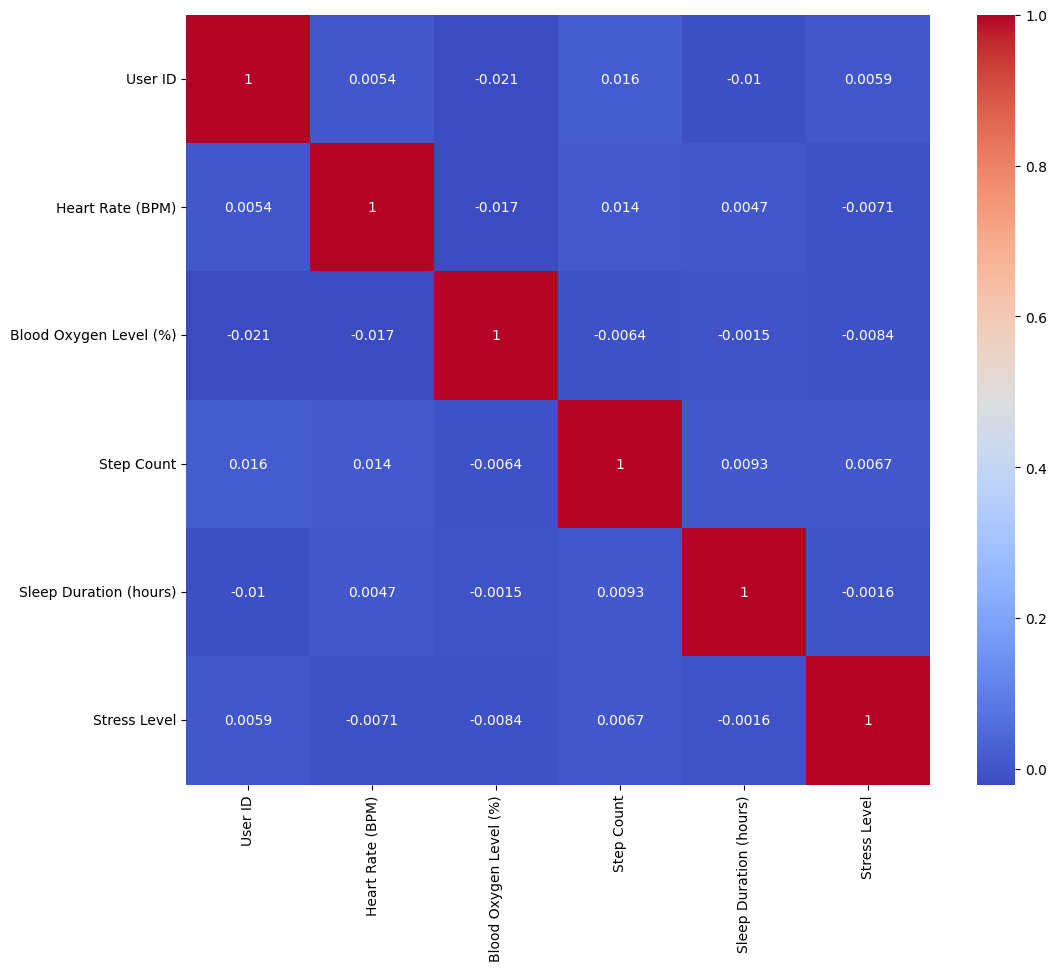

In [16]:
shd_df.plot_numeric_correlation()

In [17]:
shd_df.avg_sleep_by_steps()

C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sleep_by_steps = self.shd.groupby('Step Count Binned')['Sleep Duration (hours)'].mean().reset_index()


,Step Count Binned,Sleep Duration (hours)
0,"(-61.576, 4166.629]",6.500631
1,"(4166.629, 8332.348]",6.498625
2,"(8332.348, 12498.066]",6.503722
3,"(12498.066, 16663.785]",6.449090
4,"(16663.785, 20829.504]",6.579037
5,"(20829.504, 24995.222]",6.562670
6,"(24995.222, 29160.941]",6.541534
7,"(29160.941, 33326.66]",6.562766
8,"(33326.66, 37492.379]",6.994245
9,"(37492.379, 41658.097]",6.317918


In [18]:
shd_df.data_frame()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level,Step Count Binned
0,4174.0,58.939776,98.809650,5450.390578,7.167236,Highly Active,1.0,"(4166.629, 8332.348]"
2,1860.0,247.803052,97.052954,2826.521994,6.501197,Highly Active,5.0,"(-61.576, 4166.629]"
3,2294.0,40.000000,96.894213,13797.338044,7.367790,Actve,3.0,"(12498.066, 16663.785]"
4,2130.0,61.950165,98.583797,15679.067648,6.501197,Highly_Active,6.0,"(12498.066, 16663.785]"
5,2095.0,96.285938,94.202910,10205.992256,8.378343,Highly_Active,10.0,"(8332.348, 12498.066]"
...,...,...,...,...,...,...,...,...
9995,1524.0,78.819386,98.931927,2948.491953,7.402749,Active,7.0,"(-61.576, 4166.629]"
9996,4879.0,48.632659,95.773035,4725.623070,6.382166,Sedentary,2.0,"(4166.629, 8332.348]"
9997,2624.0,73.834442,97.945874,2571.492060,6.916549,Sedentary,4.0,"(-61.576, 4166.629]"
9998,4907.0,75.208240,98.401058,3364.788855,5.691234,Active,8.0,"(-61.576, 4166.629]"


C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sleep_by_steps = self.shd.groupby('Step Count Binned')['Sleep Duration (hours)'].mean().reset_index()


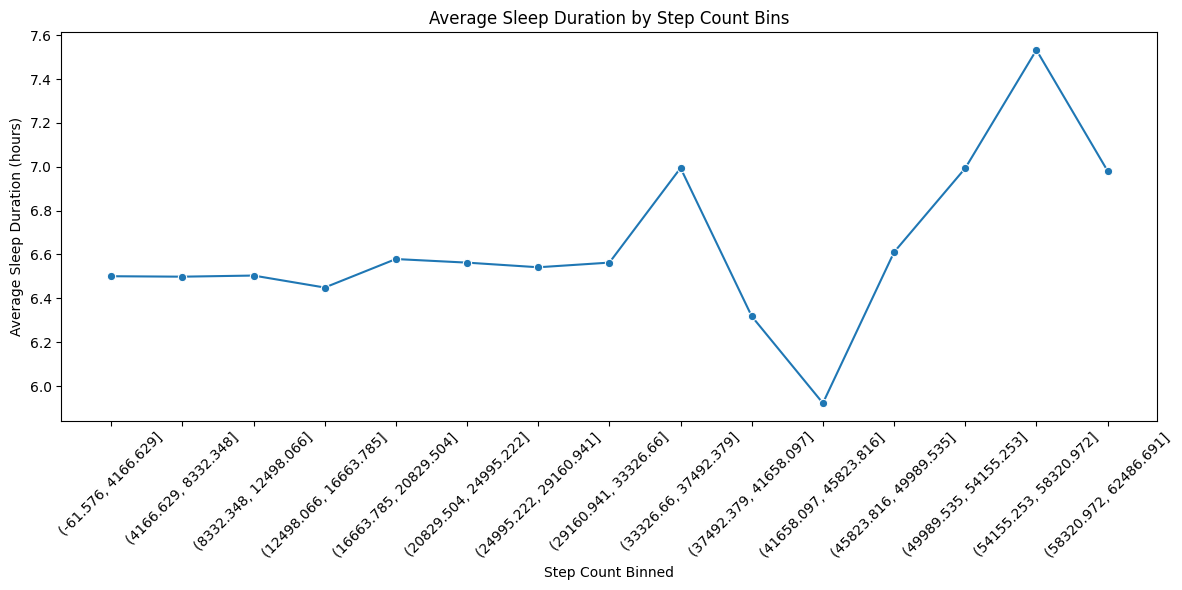

In [19]:
avg_sleep_df = shd_df.avg_sleep_by_steps()  # Compute average sleep by steps
shd_df.plot_avg_sleep_by_steps(avg_sleep_df)  # Pass the computed data to plot


In [20]:
shd_df.avg_sleep_by_activity()

,Activity Level,Sleep Duration (hours)
0,Active,6.551516
1,Actve,6.485435
2,Highly Active,6.500607
3,Highly_Active,6.492357
4,Seddentary,6.504392
5,Sedentary,6.487683


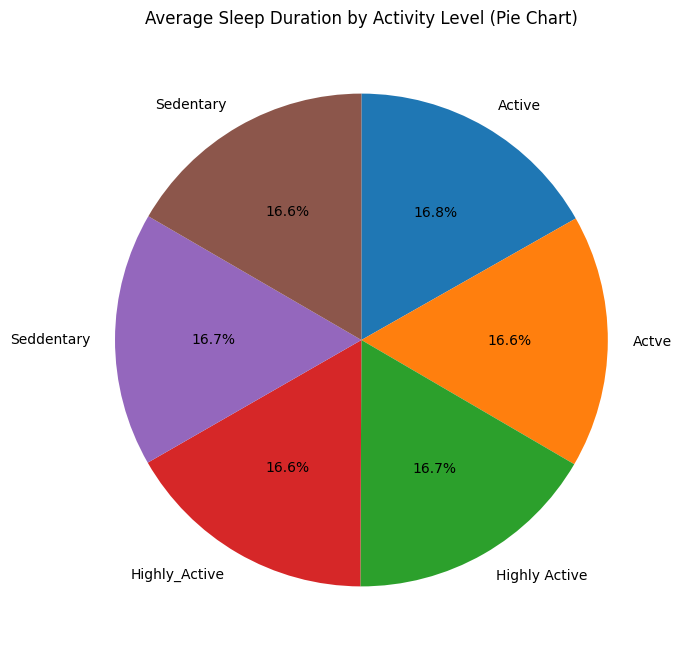

In [21]:
avg_sleep_activity_df = shd_df.avg_sleep_by_activity()
shd_df.plot_avg_sleep_by_activity_pie(avg_sleep_activity_df)


In [22]:
shd_df.avg_stress_by_steps()

C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:233: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_stress_by_steps = self.shd.groupby('Step Count Binned')['Stress Level'].mean().reset_index()


,Step Count Binned,Stress Level
0,"(-61.576, 4166.629]",5.418420
1,"(4166.629, 8332.348]",5.468738
2,"(8332.348, 12498.066]",5.469539
3,"(12498.066, 16663.785]",5.546053
4,"(16663.785, 20829.504]",5.506266
5,"(20829.504, 24995.222]",5.359813
6,"(24995.222, 29160.941]",5.379032
7,"(29160.941, 33326.66]",5.242424
8,"(33326.66, 37492.379]",5.714286
9,"(37492.379, 41658.097]",5.687500


C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:233: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_stress_by_steps = self.shd.groupby('Step Count Binned')['Stress Level'].mean().reset_index()
C:\Users\hi\AppData\Local\Temp\ipykernel_23748\454934431.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_stress_by_steps, x='Step Count Binned', y='Stress Level', palette='viridis')


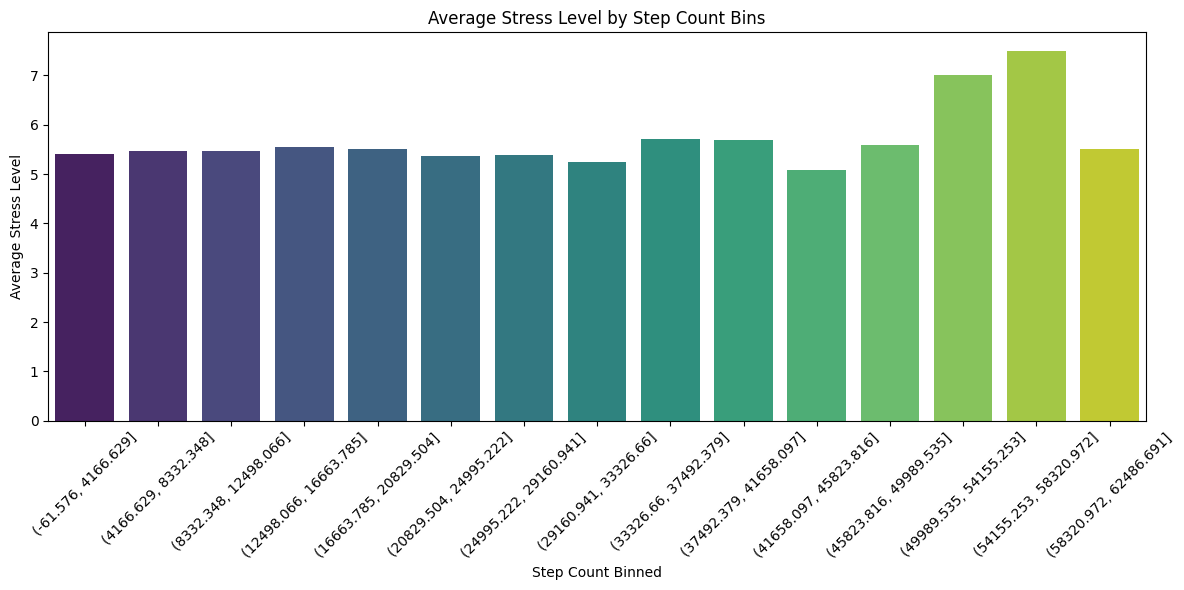

In [23]:
avg_stress_steps_df = shd_df.avg_stress_by_steps()
shd_df.plot_avg_stress_by_steps(avg_stress_steps_df)

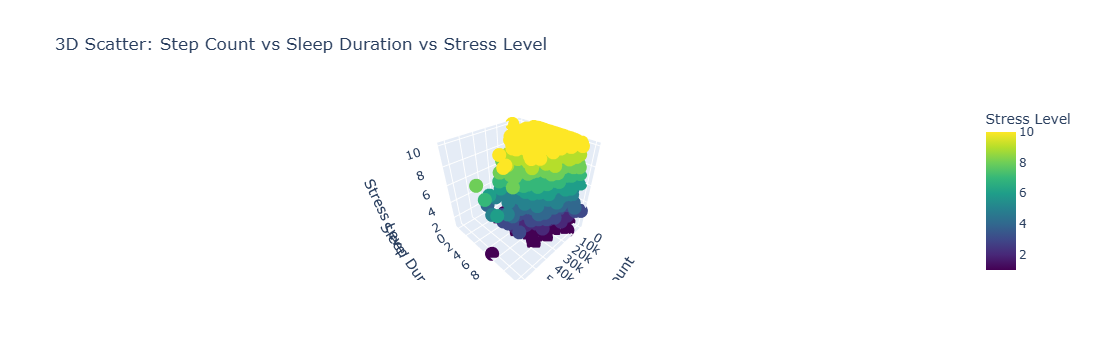

In [24]:
shd_df.plot_3d_steps_sleep_stress_interactive()

In [25]:
shd_df.avg_oxygen_and_heart_by_activity()

,Activity Level,Blood Oxygen Level (%),Heart Rate (BPM)
0,Active,97.789901,75.945976
1,Actve,97.858792,75.827658
2,Highly Active,97.817004,76.219520
3,Highly_Active,97.871876,75.857892
4,Seddentary,97.821839,75.744283
5,Sedentary,97.929078,76.322164


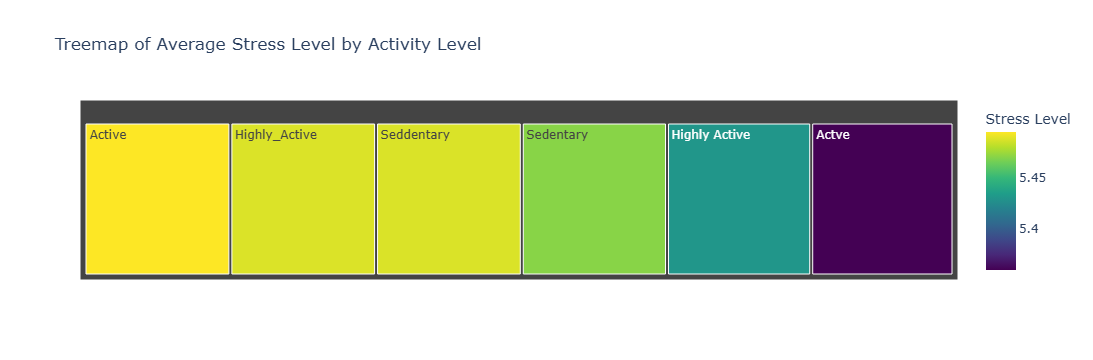

In [26]:
shd_df.plot_treemap_activity_stress()

In [27]:
shd_df.avg_oxygen_and_heart_by_activity()

,Activity Level,Blood Oxygen Level (%),Heart Rate (BPM)
0,Active,97.789901,75.945976
1,Actve,97.858792,75.827658
2,Highly Active,97.817004,76.219520
3,Highly_Active,97.871876,75.857892
4,Seddentary,97.821839,75.744283
5,Sedentary,97.929078,76.322164


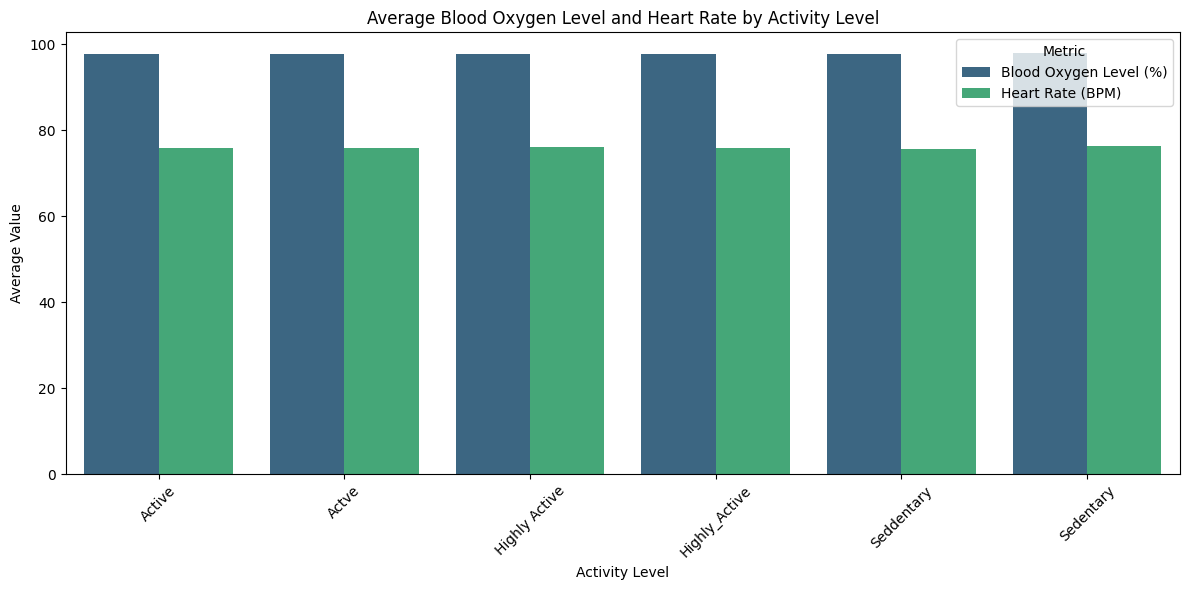

In [28]:
shd_df.plot_avg_oxygen_heart_by_activity()

In [29]:
print(shd_df.generate_create_table_statement())


        CREATE TABLE IF NOT EXISTS unclean_smartwatch_health_data (
            "User ID" FLOAT,
    "Heart Rate (BPM)" FLOAT,
    "Blood Oxygen Level (%)" FLOAT,
    "Step Count" FLOAT,
    "Sleep Duration (hours)" FLOAT,
    "Activity Level" TEXT,
    "Stress Level" FLOAT,
    "Step Count Binned" TEXT
        );
        


In [30]:
shd_df.convert_intervals_to_str(shd_df.shd)

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level,Step Count Binned
0,4174.0,58.939776,98.809650,5450.390578,7.167236,Highly Active,1.0,"(4166.629, 8332.348]"
2,1860.0,247.803052,97.052954,2826.521994,6.501197,Highly Active,5.0,"(-61.576, 4166.629]"
3,2294.0,40.000000,96.894213,13797.338044,7.367790,Actve,3.0,"(12498.066, 16663.785]"
4,2130.0,61.950165,98.583797,15679.067648,6.501197,Highly_Active,6.0,"(12498.066, 16663.785]"
5,2095.0,96.285938,94.202910,10205.992256,8.378343,Highly_Active,10.0,"(8332.348, 12498.066]"
...,...,...,...,...,...,...,...,...
9995,1524.0,78.819386,98.931927,2948.491953,7.402749,Active,7.0,"(-61.576, 4166.629]"
9996,4879.0,48.632659,95.773035,4725.623070,6.382166,Sedentary,2.0,"(4166.629, 8332.348]"
9997,2624.0,73.834442,97.945874,2571.492060,6.916549,Sedentary,4.0,"(-61.576, 4166.629]"
9998,4907.0,75.208240,98.401058,3364.788855,5.691234,Active,8.0,"(-61.576, 4166.629]"


In [31]:
# Define connection parameters
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "901473R",
    'host': "localhost",
    'port': "5432"
}

# Save the DataFrame to PostgreSQL, creating table if needed, converting intervals
shd_df.save_to_postgres(conn_params, table_name="unclean_smartwatch_health_data")

Data inserted successfully into table 'unclean_smartwatch_health_data
